In [1]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict
from enum import Enum


class ArrayPartitionTypes(Enum):
    complete = "complete"
    block = "block"
    cyclic = "cyclic"

@dataclass(frozen=True)
class ArrayPartition:
    variable: str
    dim: int
    type: ArrayPartitionTypes
    factor: int | None = None

@dataclass(frozen=True)
class MemoryOptimization:
    arrayPartition: ArrayPartition

class PipelineStyle(Enum):
    stp = "stp"
    flp = "flp"
    frp = "frp"

@dataclass(frozen=True)
class Pipeline:
    off: bool
    II: int | None = None
    rewind: bool | None = None
    style: PipelineStyle | None = None

@dataclass(frozen=True)
class Unroll:
    off: bool
    factor: int | None = None
    skip_exit_check: bool | None = None

@dataclass(frozen=True)
class Dataflow:
    pass


@dataclass(frozen=True)
class StructureOptimization:
    label: str
    pipeline: Pipeline | None = None
    unroll: Unroll | None = None
    dataflow: Dataflow | None = None


@dataclass(frozen=True)
class OptimizationStrategy:
    memory: list[MemoryOptimization]
    structure: list[StructureOptimization]

@dataclass(frozen=True)
class HLSReport:
    reportName: str
    latency_ns: int
    bram: int
    dsp: int
    ff: int
    lut: int
    uram: int
    taskSpecificInfo: dict[str, any]
    optimizations: OptimizationStrategy

def toDictRepresentation(report: HLSReport):
    result = {
        "ReportName": [report.reportName],
        "M": [report.taskSpecificInfo["M"]],
        "P": [report.taskSpecificInfo["P"]],
        "N": [report.taskSpecificInfo["N"]],
        "Latency_ns": [report.latency_ns],
        "BRAM": [report.bram],
        "DSP": [report.dsp],
        "FF": [report.ff],
        "LUT": [report.lut],
        "URAM": [report.uram],
    }

    variables: list[str] = []
    dim: list[int] = []
    type: list[ArrayPartitionTypes] = []
    factor: list[int | None] = []
    for m in report.optimizations.memory:
        variables.append(m.arrayPartition.variable)
        dim.append(m.arrayPartition.dim)
        type.append(m.arrayPartition.type.name)
        factor.append(m.arrayPartition.factor)

    memory = {
        "ReportName": [report.reportName for i in range(len(variables))],
        "Variables": variables,
        "Dim": dim,
        "Type": type,
        "Factor": factor
    }


    labels: list[str] = []
    optimizationTechniques: list[str] = []
    
    pipelineOff: list[bool | None] = []
    pipelineII: list[int | None] = []
    pipelineRewind: list[bool | None] = []
    pipelineStyle: list[str | None] = []

    unrollOff: list[bool | None] = []
    unrollFactor: list[int | None] = []
    unrollSkipExitCheck: list[bool | None] = []

    for s in report.optimizations.structure:
        labels.append(s.label)

        usedOptimizations: list[str] = []

        if s.dataflow != None:
            usedOptimizations.append("Dataflow")
        if s.pipeline != None:
            usedOptimizations.append("Pipeline")
            pipelineOff.append(s.pipeline.off)
            pipelineII.append(s.pipeline.II)
            pipelineRewind.append(s.pipeline.rewind)
            pipelineStyle.append(s.pipeline.style)
        else:
            pipelineOff.append(None)
            pipelineII.append(None)
            pipelineRewind.append(None)
            pipelineStyle.append(None)


        if s.unroll != None:
            usedOptimizations.append("Unroll")
            unrollOff.append(s.unroll.off)
            unrollFactor.append(s.unroll.factor)
            unrollSkipExitCheck.append(s.unroll.skip_exit_check)
        else:
            unrollOff.append(None)
            unrollFactor.append(None)
            unrollSkipExitCheck.append(None)

        optimizationTechniques.append(str(usedOptimizations))



    optimizations = {
        "ReportName": [report.reportName for i in range(len(labels))],
        "Label": labels,
        "Techniques": optimizationTechniques,
        "Pipeline - Off": pipelineOff,
        "Pipeline - II": pipelineII,
        "Pipeline - Style": pipelineStyle,
        "Pipeline - Rewind": pipelineRewind,
        "Unroll - Off": unrollOff,
        "Unroll - Factor": unrollFactor,
        "Unroll - SkipExitCheck": unrollSkipExitCheck,
    }


    return result, memory, optimizations

def concatDictRepresentation(result0: dict[str, list[any]], memory0: dict[str, list[any]], optimizations0: dict[str, list[any]], result1: dict[str, list[any]], memory1: dict[str, list[any]], optimizations1: dict[str, list[any]]):
    for key, value in result0.items():
        result0[key].extend(result1[key])

    for key, value in memory0.items():
        memory0[key].extend(memory1[key])
    
    for key, value in optimizations0.items():
        optimizations0[key].extend(optimizations1[key])

    return result0, memory0, optimizations0


In [2]:
reports: list[HLSReport] = []

reports.append(HLSReport(
    reportName="Optimization 0",
    latency_ns=41300,
    bram=0,
    dsp=4,
    ff=192,
    lut=417,
    uram=0,
    taskSpecificInfo={
        "M": 16,
        "P": 4,
        "N": 16
    },
    optimizations=OptimizationStrategy(
        memory=[],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=True)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 1",
    latency_ns=5620,
    bram=0,
    dsp=16,
    ff=268,
    lut=311,
    uram=0,
    taskSpecificInfo={
        "M": 16,
        "P": 4,
        "N": 16
    },
    optimizations=OptimizationStrategy(
        memory=[
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "mulValue", dim=1, type=ArrayPartitionTypes.complete
            ))
        ],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 2",
    latency_ns=2590,
    bram=0,
    dsp=16,
    ff=33,
    lut=366,
    uram=0,
    taskSpecificInfo={
        "M": 16,
        "P": 4,
        "N": 16
    },
    optimizations=OptimizationStrategy(
        memory=[
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "mulValue", dim=1, type=ArrayPartitionTypes.complete
            ))
        ],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 3",
    latency_ns=2680,
    bram=0,
    dsp=16,
    ff=5900,
    lut=1321,
    uram=0,
    taskSpecificInfo={
        "M": 16,
        "P": 4,
        "N": 16
    },
    optimizations=OptimizationStrategy(
        memory=[
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "mulValue", dim=1, type=ArrayPartitionTypes.complete
            ))
        ],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 4",
    latency_ns=1310,
    bram=0,
    dsp=32,
    ff=31,
    lut=518,
    uram=0,
    taskSpecificInfo={
        "M": 16,
        "P": 4,
        "N": 16
    },
    optimizations=OptimizationStrategy(
        memory=[
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "C", dim=2, type=ArrayPartitionTypes.cyclic, factor=2
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=2, type=ArrayPartitionTypes.cyclic, factor=2
            )),
            MemoryOptimization(ArrayPartition(
                "mulValue", dim=1, type=ArrayPartitionTypes.complete
            ))
        ],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False), unroll=Unroll(off=False, factor=2)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 5",
    latency_ns=670,
    bram=0,
    dsp=64,
    ff=29,
    lut=882,
    uram=0,
    taskSpecificInfo={
        "M": 16,
        "P": 4,
        "N": 16
    },
    optimizations=OptimizationStrategy(
        memory=[
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "C", dim=2, type=ArrayPartitionTypes.cyclic, factor=4
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=2, type=ArrayPartitionTypes.cyclic, factor=4
            )),
            MemoryOptimization(ArrayPartition(
                "mulValue", dim=1, type=ArrayPartitionTypes.complete
            ))
        ],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False), unroll=Unroll(off=False, factor=4)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 6",
    latency_ns=360,
    bram=0,
    dsp=128,
    ff=173,
    lut=1624,
    uram=0,
    taskSpecificInfo={
        "M": 16,
        "P": 4,
        "N": 16
    },
    optimizations=OptimizationStrategy(
        memory=[
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "C", dim=2, type=ArrayPartitionTypes.cyclic, factor=8
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=2, type=ArrayPartitionTypes.cyclic, factor=8
            )),
            MemoryOptimization(ArrayPartition(
                "mulValue", dim=1, type=ArrayPartitionTypes.complete
            ))
        ],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False), unroll=Unroll(off=False, factor=8)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 7",
    latency_ns=340,
    bram=0,
    dsp=256,
    ff=5647,
    lut=2996,
    uram=0,
    taskSpecificInfo={
        "M": 16,
        "P": 4,
        "N": 16
    },
    optimizations=OptimizationStrategy(
        memory=[
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "C", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "mulValue", dim=1, type=ArrayPartitionTypes.complete
            ))
        ],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopP", unroll=Unroll(off=False), pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 8",
    latency_ns=180,
    bram=0,
    dsp=512,
    ff=5648,
    lut=5911,
    uram=0,
    taskSpecificInfo={
        "M": 16,
        "P": 4,
        "N": 16
    },
    optimizations=OptimizationStrategy(
        memory=[
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "C", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "A", dim=1, type=ArrayPartitionTypes.cyclic, factor=2
            )),
            MemoryOptimization(ArrayPartition(
                "C", dim=1, type=ArrayPartitionTypes.cyclic, factor=2
            )),
            MemoryOptimization(ArrayPartition(
                "mulValue", dim=1, type=ArrayPartitionTypes.complete
            ))
        ],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", unroll=Unroll(off=False, factor=2), pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", unroll=Unroll(off=False), pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 9",
    latency_ns=100,
    bram=0,
    dsp=1024,
    ff=5647,
    lut=11767,
    uram=0,
    taskSpecificInfo={
        "M": 16,
        "P": 4,
        "N": 16
    },
    optimizations=OptimizationStrategy(
        memory=[
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "C", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "A", dim=1, type=ArrayPartitionTypes.cyclic, factor=4
            )),
            MemoryOptimization(ArrayPartition(
                "C", dim=1, type=ArrayPartitionTypes.cyclic, factor=4
            )),
            MemoryOptimization(ArrayPartition(
                "mulValue", dim=1, type=ArrayPartitionTypes.complete
            ))
        ],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", unroll=Unroll(off=False, factor=4), pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", unroll=Unroll(off=False), pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 10",
    latency_ns=60,
    bram=0,
    dsp=2048,
    ff=5646,
    lut=23479,
    uram=0,
    taskSpecificInfo={
        "M": 16,
        "P": 4,
        "N": 16
    },
    optimizations=OptimizationStrategy(
        memory=[
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "C", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "A", dim=1, type=ArrayPartitionTypes.cyclic, factor=8
            )),
            MemoryOptimization(ArrayPartition(
                "C", dim=1, type=ArrayPartitionTypes.cyclic, factor=8
            )),
            MemoryOptimization(ArrayPartition(
                "mulValue", dim=1, type=ArrayPartitionTypes.complete
            ))
        ],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", unroll=Unroll(off=False, factor=8), pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", unroll=Unroll(off=False), pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

In [3]:
prevResult = {}
prevMemory = {}
prevOptimizations = {}

for i in range(len(reports)):
    report = reports[i]

    newResult, newMemory, newOptimizations = toDictRepresentation(report)

    if (i < 1):
        prevResult = newResult
        prevMemory = newMemory
        prevOptimizations = newOptimizations
    else:
        prevResult, prevMemory, prevOptimizations, concatDictRepresentation(prevResult, prevMemory, prevOptimizations, newResult, newMemory, newOptimizations)

In [4]:
ReportNameCollection = prevResult["ReportName"]
Result = copy.deepcopy(prevResult)
Result.pop("ReportName")

dfResults = pd.DataFrame(Result, index=ReportNameCollection)
dfResults

,M,P,N,Latency_ns,BRAM,DSP,FF,LUT,URAM
Optimization 0,16,4,16,41300,0,4,192,417,0
Optimization 1,16,4,16,5620,0,16,268,311,0
Optimization 2,16,4,16,2590,0,16,33,366,0
Optimization 3,16,4,16,2680,0,16,5900,1321,0
Optimization 4,16,4,16,1310,0,32,31,518,0
Optimization 5,16,4,16,670,0,64,29,882,0
Optimization 6,16,4,16,360,0,128,173,1624,0
Optimization 7,16,4,16,340,0,256,5647,2996,0
Optimization 8,16,4,16,180,0,512,5648,5911,0
Optimization 9,16,4,16,100,0,1024,5647,11767,0


In [5]:
ReportNameCollection = prevMemory["ReportName"]
Memory = copy.deepcopy(prevMemory)
Memory.pop("ReportName")

dfMemory = pd.DataFrame(Memory, index=ReportNameCollection)
dfMemory

,Variables,Dim,Type,Factor
Optimization 1,A,2,complete,NaN
Optimization 1,B,1,complete,NaN
Optimization 1,mulValue,1,complete,NaN
Optimization 2,A,2,complete,NaN
Optimization 2,B,1,complete,NaN
Optimization 2,mulValue,1,complete,NaN
Optimization 3,A,2,complete,NaN
Optimization 3,B,1,complete,NaN
Optimization 3,mulValue,1,complete,NaN
Optimization 4,A,2,complete,NaN


In [6]:
ReportNameCollection = prevOptimizations["ReportName"]
Optimizations = copy.deepcopy(prevOptimizations)
Optimizations.pop("ReportName")

dfOptimizations = pd.DataFrame(Optimizations, index=ReportNameCollection)
dfOptimizations

,Label,Techniques,Pipeline - Off,Pipeline - II,Pipeline - Style,Pipeline - Rewind,Unroll - Off,Unroll - Factor,Unroll - SkipExitCheck
Optimization 0,Function Base,['Pipeline'],True,None,None,None,None,NaN,None
Optimization 0,LoopM,['Pipeline'],True,None,None,None,None,NaN,None
Optimization 0,LoopP,['Pipeline'],True,None,None,None,None,NaN,None
Optimization 0,LoopN,['Pipeline'],True,None,None,None,None,NaN,None
Optimization 1,Function Base,['Pipeline'],True,None,None,None,None,NaN,None
Optimization 1,LoopM,['Pipeline'],True,None,None,None,None,NaN,None
Optimization 1,LoopP,['Pipeline'],True,None,None,None,None,NaN,None
Optimization 1,LoopN,"['Pipeline', 'Unroll']",False,None,None,None,False,NaN,None
Optimization 2,Function Base,['Pipeline'],True,None,None,None,None,NaN,None
Optimization 2,LoopM,['Pipeline'],True,None,None,None,None,NaN,None


In [7]:
def contains(strings: list[str], match: str):
    for i in range(len(strings)):
        if (strings[i] == match):
            return i
    return -1

dfOptimizations["Unroll - Factor"].notna()

indexes: list[str] = []
labels: list[str] = []
pipelineStrs: list[str] = []
unrollStrs: list[str] = []
dataflowStrs: list[str] = []

for i in range(len(dfOptimizations.index)):
    indexes.append("Opt " + str(dfOptimizations.index[i]).split(" ")[1])
    labels.append(dfOptimizations["Label"].iloc[i])
    techniques = dfOptimizations["Techniques"].iloc[i].replace("'", "").replace("[", "").replace("]", "").split(",")

    if contains(techniques, "Pipeline") > -1:
        pipelineStr = "Pipeline "

        if (dfOptimizations["Pipeline - Off"].iloc[i] == True):
            pipelineStr += "OFF "
        
        if (dfOptimizations["Pipeline - II"].iloc[i] != None):
            pipelineStr += "II=" + str(dfOptimizations["Pipeline - II"].iloc[i]) + " "

        if (dfOptimizations["Pipeline - Style"].iloc[i] != None):
            pipelineStr += "style=" + str(dfOptimizations["Pipeline - Style"].iloc[i].name) + " "

        if (dfOptimizations["Pipeline - Rewind"].iloc[i] != None):
            pipelineStr += "rewind=" + str(dfOptimizations["Pipeline - Rewind"].iloc[i]) + " "

        pipelineStrs.append(pipelineStr)
    else:
        pipelineStrs.append("")

    if contains(techniques, "Unroll") > -1:
        unrollStr = "Unroll "

        if (dfOptimizations["Unroll - Off"].iloc[i] == True):
            unrollStr += "OFF "
        if (pd.isna(dfOptimizations["Unroll - Factor"].iloc[i]) == False):
            unrollStr += "factor=" + str(dfOptimizations["Unroll - Factor"].iloc[i]) + " "
        if (dfOptimizations["Unroll - SkipExitCheck"].iloc[i] != None):
            unrollStr += "skipExitCheck=True "

        unrollStrs.append(unrollStr)
    else:
        unrollStrs.append("")
    if contains(techniques, "Dataflow") > -1:
        dataFlowStr = "Dataflow"
        dataflowStrs.append(dataFlowStr)
    else:
        dataflowStrs.append("")

dfOptimizationsFormatted = pd.DataFrame({
    "Label": labels,
    "Pipeline": pipelineStrs,
    "Unroll": unrollStrs,
    "Dataflow": dataflowStrs
}, index=indexes)


print(dfOptimizationsFormatted.to_latex())


\begin{tabular}{lllll}
\toprule
 & Label & Pipeline & Unroll & Dataflow \\
\midrule
Opt 0 & Function Base & Pipeline OFF  &  &  \\
Opt 0 & LoopM & Pipeline OFF  &  &  \\
Opt 0 & LoopP & Pipeline OFF  &  &  \\
Opt 0 & LoopN & Pipeline OFF  &  &  \\
Opt 1 & Function Base & Pipeline OFF  &  &  \\
Opt 1 & LoopM & Pipeline OFF  &  &  \\
Opt 1 & LoopP & Pipeline OFF  &  &  \\
Opt 1 & LoopN & Pipeline  &  &  \\
Opt 2 & Function Base & Pipeline OFF  &  &  \\
Opt 2 & LoopM & Pipeline OFF  &  &  \\
Opt 2 & LoopP & Pipeline  &  &  \\
Opt 2 & LoopN & Pipeline  &  &  \\
Opt 3 & Function Base & Pipeline OFF  &  &  \\
Opt 3 & LoopM & Pipeline  &  &  \\
Opt 3 & LoopP & Pipeline  &  &  \\
Opt 3 & LoopN & Pipeline  &  &  \\
Opt 4 & Function Base & Pipeline OFF  &  &  \\
Opt 4 & LoopM & Pipeline  &  &  \\
Opt 4 & LoopP & Pipeline  &  &  \\
Opt 4 & LoopN & Pipeline  &  &  \\
Opt 5 & Function Base & Pipeline OFF  &  &  \\
Opt 5 & LoopM & Pipeline  &  &  \\
Opt 5 & LoopP & Pipeline  &  &  \\
Opt 5 & LoopN &

In [8]:
dfOptimizations["Techniques"].iloc[7].replace("'", "").replace("[", "").replace("]", "").split(",")

['Pipeline', ' Unroll']

In [9]:
dfOptimizations.drop(columns=["Pipeline - II", "Pipeline - Style", "Pipeline - Rewind"])

,Label,Techniques,Pipeline - Off,Unroll - Off,Unroll - Factor,Unroll - SkipExitCheck
Optimization 0,Function Base,['Pipeline'],True,None,NaN,None
Optimization 0,LoopM,['Pipeline'],True,None,NaN,None
Optimization 0,LoopP,['Pipeline'],True,None,NaN,None
Optimization 0,LoopN,['Pipeline'],True,None,NaN,None
Optimization 1,Function Base,['Pipeline'],True,None,NaN,None
Optimization 1,LoopM,['Pipeline'],True,None,NaN,None
Optimization 1,LoopP,['Pipeline'],True,None,NaN,None
Optimization 1,LoopN,"['Pipeline', 'Unroll']",False,False,NaN,None
Optimization 2,Function Base,['Pipeline'],True,None,NaN,None
Optimization 2,LoopM,['Pipeline'],True,None,NaN,None


In [10]:
# Compute pct resource usage
zcu104 = {
    "LUT": 230400,
    "BRAM": 312,
    "FF": 460800,
    "URAM": 96,
    "DSP": 1728,
}

dfResults["BRAM%"] = dfResults["BRAM"] / zcu104["BRAM"] * 100
dfResults["DSP%"] = dfResults["DSP"] / zcu104["DSP"] * 100
dfResults["FF%"] = dfResults["FF"] / zcu104["FF"] * 100
dfResults["LUT%"] = dfResults["LUT"] / zcu104["LUT"] * 100
dfResults["URAM%"] = dfResults["URAM"] / zcu104["URAM"] * 100

dfResults["(FF + LUT)%"] = ((dfResults["LUT"] / zcu104["LUT"] + dfResults["FF"] / zcu104["FF"]) / 2) * 100

C:\Users\lions\AppData\Local\Temp\ipykernel_28852\1795218927.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_sorted = dfResults["(FF + LUT)%"][sorted_idx]
C:\Users\lions\AppData\Local\Temp\ipykernel_28852\1795218927.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_sorted = dfResults["Latency_ns"][sorted_idx]
C:\Users\lions\AppData\Local\Temp\ipykernel_28852\1795218927.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lo

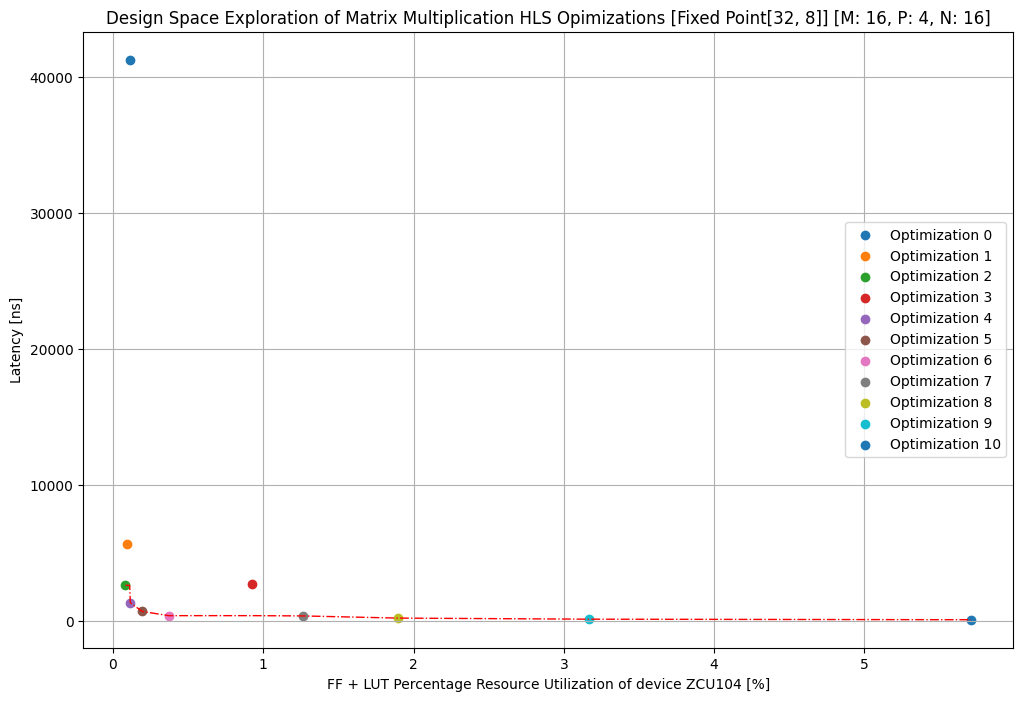

In [11]:
sorted_idx = np.argsort(dfResults["(FF + LUT)%"])
x_sorted = dfResults["(FF + LUT)%"][sorted_idx]
y_sorted = dfResults["Latency_ns"][sorted_idx]

# Find lower envelope points
lower_x = [x_sorted[0]]
lower_y = [y_sorted[0]]

for xi, yi in zip(x_sorted[1:], y_sorted[1:]):
    if yi < lower_y[-1]:
        lower_x.append(xi)
        lower_y.append(yi)
    else:
        # Keep previous lowest as a “step”
        lower_x.append(xi)
        lower_y.append(lower_y[-1])



fig = plt.figure()
fig.set_size_inches(12, 8)

ax = fig.add_subplot(1, 1, 1)

handles: list[any] = []
for i in range(len(dfResults["Latency_ns"])):
    handles.append(ax.scatter(dfResults["(FF + LUT)%"][i], dfResults["Latency_ns"][i], label=dfResults.index[i]))

ax.plot(lower_x, lower_y, color='red', linewidth=1, linestyle="-.", label='Lower Barrier')

ax.legend(handles=handles, loc="center right")
ax.set_xlabel("FF + LUT Percentage Resource Utilization of device ZCU104 [%]")
ax.set_ylabel("Latency [ns]")
ax.set_title("Design Space Exploration of Matrix Multiplication HLS Opimizations [Fixed Point[32, 8]] [M: 16, P: 4, N: 16]")
#ax.set_ylim([0, 12000])
#ax.set_xlim([0, 20])

#ax.scatter(dfResults["(FF + LUT)%"], dfResults["Latency_ns"])
ax.grid(True)

C:\Users\lions\AppData\Local\Temp\ipykernel_28852\3513443057.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_sorted = dfResults["LUT%"][sorted_idx]
C:\Users\lions\AppData\Local\Temp\ipykernel_28852\3513443057.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_sorted = dfResults["Latency_ns"][sorted_idx]
C:\Users\lions\AppData\Local\Temp\ipykernel_28852\3513443057.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lower_x =

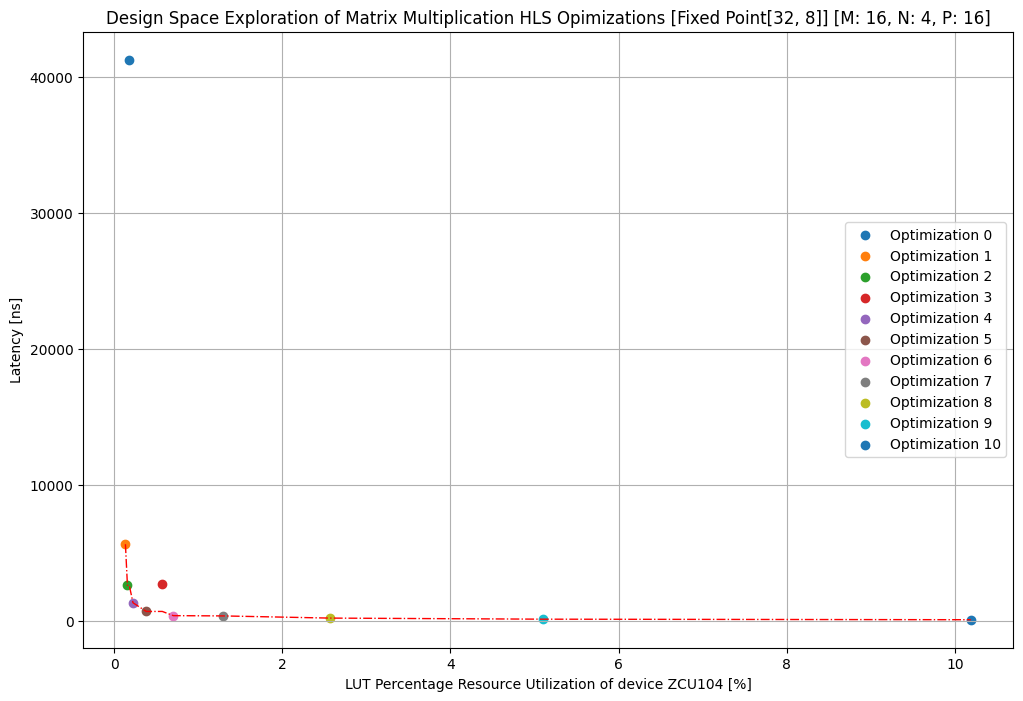

In [12]:
sorted_idx = np.argsort(dfResults["LUT%"])
x_sorted = dfResults["LUT%"][sorted_idx]
y_sorted = dfResults["Latency_ns"][sorted_idx]

# Find lower envelope points
lower_x = [x_sorted[0]]
lower_y = [y_sorted[0]]

for xi, yi in zip(x_sorted[1:], y_sorted[1:]):
    if yi < lower_y[-1]:
        lower_x.append(xi)
        lower_y.append(yi)
    else:
        # Keep previous lowest as a “step”
        lower_x.append(xi)
        lower_y.append(lower_y[-1])



fig = plt.figure()
fig.set_size_inches(12, 8)

ax = fig.add_subplot(1, 1, 1)

handles: list[any] = []
for i in range(len(dfResults["Latency_ns"])):
    handles.append(ax.scatter(dfResults["LUT%"][i], dfResults["Latency_ns"][i], label=dfResults.index[i]))

ax.plot(lower_x, lower_y, color='red', linewidth=1, linestyle="-.", label='Lower Barrier')

ax.legend(handles=handles, loc="center right")
ax.set_xlabel("LUT Percentage Resource Utilization of device ZCU104 [%]")
ax.set_ylabel("Latency [ns]")
ax.set_title("Design Space Exploration of Matrix Multiplication HLS Opimizations [Fixed Point[32, 8]] [M: 16, N: 4, P: 16]")
#ax.set_ylim([0, 12000])
#ax.set_xlim([0, 20])

#ax.scatter(dfResults["(FF + LUT)%"], dfResults["Latency_ns"])
ax.grid(True)

C:\Users\lions\AppData\Local\Temp\ipykernel_28852\1603218765.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_sorted = dfResults["FF%"][sorted_idx]
C:\Users\lions\AppData\Local\Temp\ipykernel_28852\1603218765.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_sorted = dfResults["Latency_ns"][sorted_idx]
C:\Users\lions\AppData\Local\Temp\ipykernel_28852\1603218765.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lower_x = 

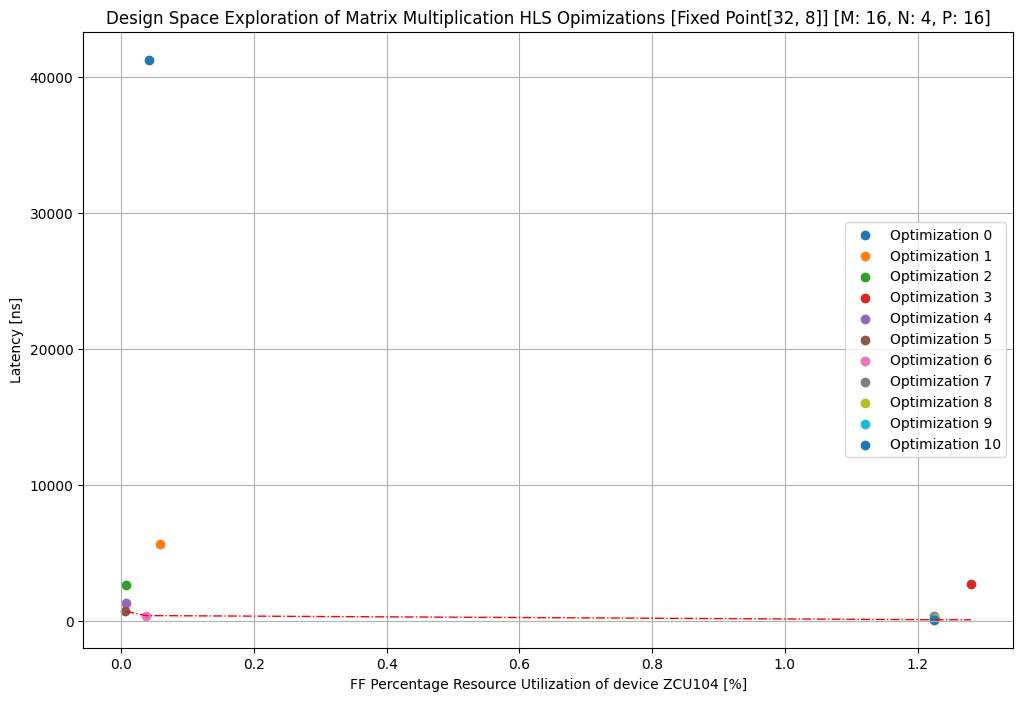

In [13]:
sorted_idx = np.argsort(dfResults["FF%"])
x_sorted = dfResults["FF%"][sorted_idx]
y_sorted = dfResults["Latency_ns"][sorted_idx]

# Find lower envelope points
lower_x = [x_sorted[0]]
lower_y = [y_sorted[0]]

for xi, yi in zip(x_sorted[1:], y_sorted[1:]):
    if yi < lower_y[-1]:
        lower_x.append(xi)
        lower_y.append(yi)
    else:
        # Keep previous lowest as a “step”
        lower_x.append(xi)
        lower_y.append(lower_y[-1])



fig = plt.figure()
fig.set_size_inches(12, 8)

ax = fig.add_subplot(1, 1, 1)

handles: list[any] = []
for i in range(len(dfResults["Latency_ns"])):
    handles.append(ax.scatter(dfResults["FF%"][i], dfResults["Latency_ns"][i], label=dfResults.index[i]))

ax.plot(lower_x, lower_y, color='red', linewidth=1, linestyle="-.", label='Lower Barrier')

ax.legend(handles=handles, loc="center right")
ax.set_xlabel("FF Percentage Resource Utilization of device ZCU104 [%]")
ax.set_ylabel("Latency [ns]")
ax.set_title("Design Space Exploration of Matrix Multiplication HLS Opimizations [Fixed Point[32, 8]] [M: 16, N: 4, P: 16]")
#ax.set_ylim([0, 12000])
#ax.set_xlim([0, 20])

#ax.scatter(dfResults["(FF + LUT)%"], dfResults["Latency_ns"])
ax.grid(True)

C:\Users\lions\AppData\Local\Temp\ipykernel_28852\1074702916.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_sorted = dfResults["DSP%"][sorted_idx]
C:\Users\lions\AppData\Local\Temp\ipykernel_28852\1074702916.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_sorted = dfResults["Latency_ns"][sorted_idx]
C:\Users\lions\AppData\Local\Temp\ipykernel_28852\1074702916.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lower_x =

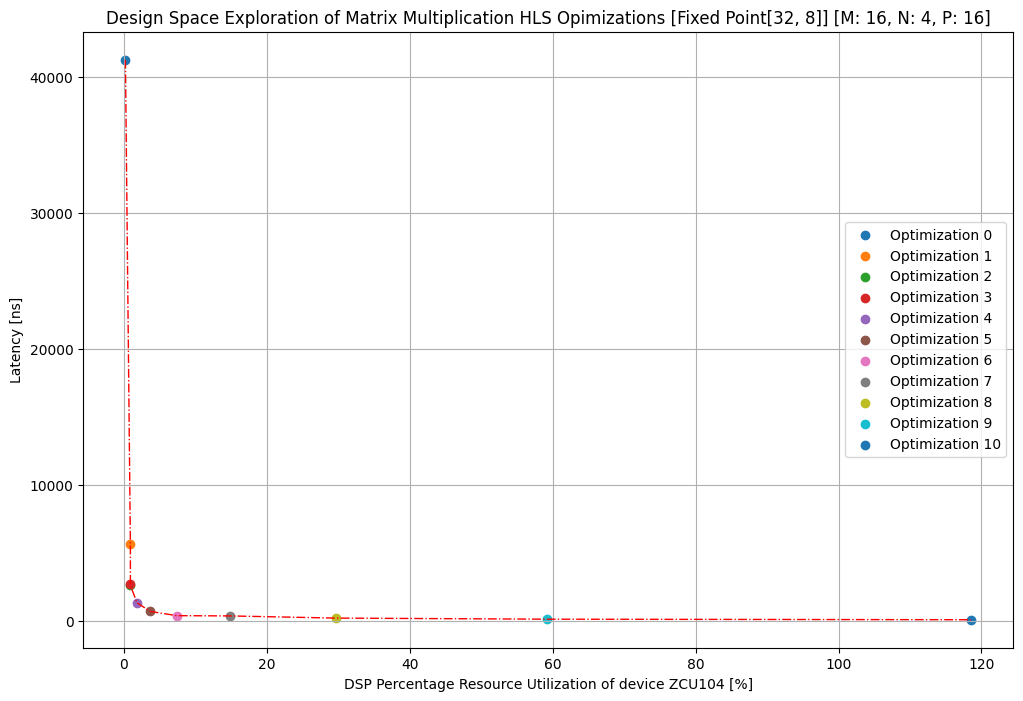

In [14]:
sorted_idx = np.argsort(dfResults["DSP%"])
x_sorted = dfResults["DSP%"][sorted_idx]
y_sorted = dfResults["Latency_ns"][sorted_idx]

# Find lower envelope points
lower_x = [x_sorted[0]]
lower_y = [y_sorted[0]]

for xi, yi in zip(x_sorted[1:], y_sorted[1:]):
    if yi < lower_y[-1]:
        lower_x.append(xi)
        lower_y.append(yi)
    else:
        # Keep previous lowest as a “step”
        lower_x.append(xi)
        lower_y.append(lower_y[-1])



fig = plt.figure()
fig.set_size_inches(12, 8)

ax = fig.add_subplot(1, 1, 1)

handles: list[any] = []
for i in range(len(dfResults["Latency_ns"])):
    handles.append(ax.scatter(dfResults["DSP%"][i], dfResults["Latency_ns"][i], label=dfResults.index[i]))

ax.plot(lower_x, lower_y, color='red', linewidth=1, linestyle="-.", label='Lower Barrier')

ax.legend(handles=handles, loc="center right")
ax.set_xlabel("DSP Percentage Resource Utilization of device ZCU104 [%]")
ax.set_ylabel("Latency [ns]")
ax.set_title("Design Space Exploration of Matrix Multiplication HLS Opimizations [Fixed Point[32, 8]] [M: 16, N: 4, P: 16]")
#ax.set_ylim([0, 12000])
#ax.set_xlim([0, 20])

#ax.scatter(dfResults["(FF + LUT)%"], dfResults["Latency_ns"])
ax.grid(True)

C:\Users\lions\AppData\Local\Temp\ipykernel_28852\1915668141.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_sorted = dfResults["(FF + LUT)%"][sorted_idx]
C:\Users\lions\AppData\Local\Temp\ipykernel_28852\1915668141.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_sorted = dfResults["Latency_ns"][sorted_idx]
C:\Users\lions\AppData\Local\Temp\ipykernel_28852\1915668141.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lo

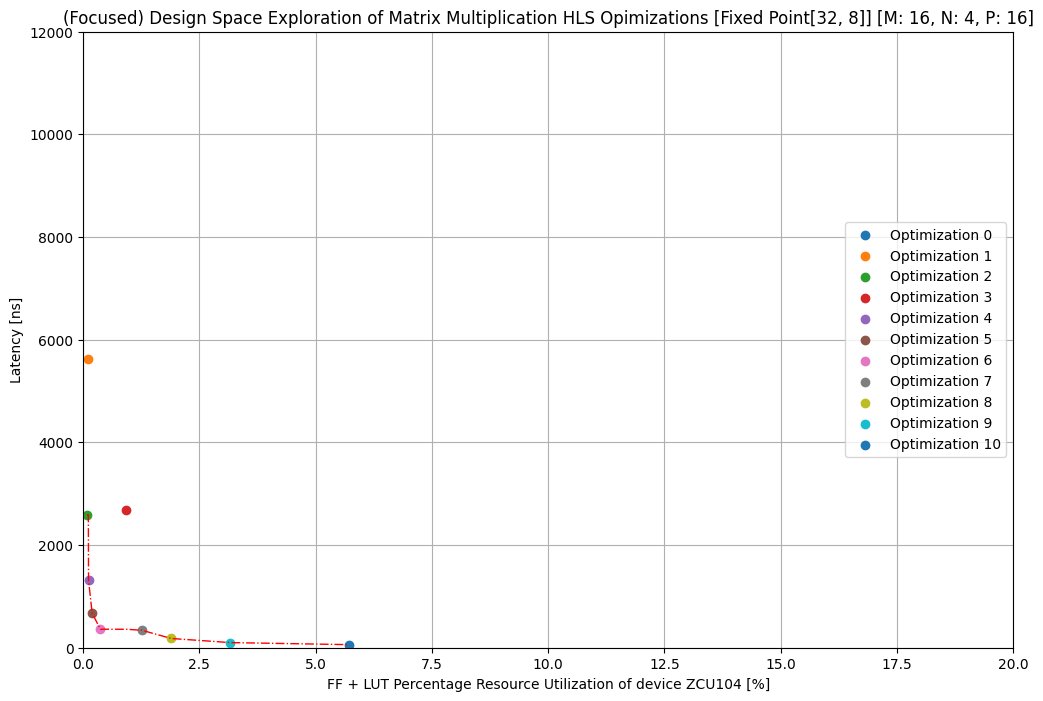

In [15]:
sorted_idx = np.argsort(dfResults["(FF + LUT)%"])
x_sorted = dfResults["(FF + LUT)%"][sorted_idx]
y_sorted = dfResults["Latency_ns"][sorted_idx]

# Find lower envelope points
lower_x = [x_sorted[0]]
lower_y = [y_sorted[0]]

for xi, yi in zip(x_sorted[1:], y_sorted[1:]):
    if yi < lower_y[-1]:
        lower_x.append(xi)
        lower_y.append(yi)
    else:
        # Keep previous lowest as a “step”
        lower_x.append(xi)
        lower_y.append(lower_y[-1])



fig = plt.figure()
fig.set_size_inches(12, 8)

ax = fig.add_subplot(1, 1, 1)

handles: list[any] = []
for i in range(len(dfResults["Latency_ns"])):
    handles.append(ax.scatter(dfResults["(FF + LUT)%"][i], dfResults["Latency_ns"][i], label=dfResults.index[i]))

ax.plot(lower_x, lower_y, color='red', linewidth=1, linestyle="-.", label='Lower Barrier')

ax.legend(handles=handles, loc="center right")
ax.set_xlabel("FF + LUT Percentage Resource Utilization of device ZCU104 [%]")
ax.set_ylabel("Latency [ns]")
ax.set_title("(Focused) Design Space Exploration of Matrix Multiplication HLS Opimizations [Fixed Point[32, 8]] [M: 16, N: 4, P: 16]")
ax.set_ylim([0, 12000])
ax.set_xlim([0, 20])

#ax.scatter(dfResults["(FF + LUT)%"], dfResults["Latency_ns"])
ax.grid(True)

C:\Users\lions\AppData\Local\Temp\ipykernel_28852\4007113658.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_sorted = dfResults["DSP%"][sorted_idx]
C:\Users\lions\AppData\Local\Temp\ipykernel_28852\4007113658.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_sorted = dfResults["Latency_ns"][sorted_idx]
C:\Users\lions\AppData\Local\Temp\ipykernel_28852\4007113658.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lower_x =

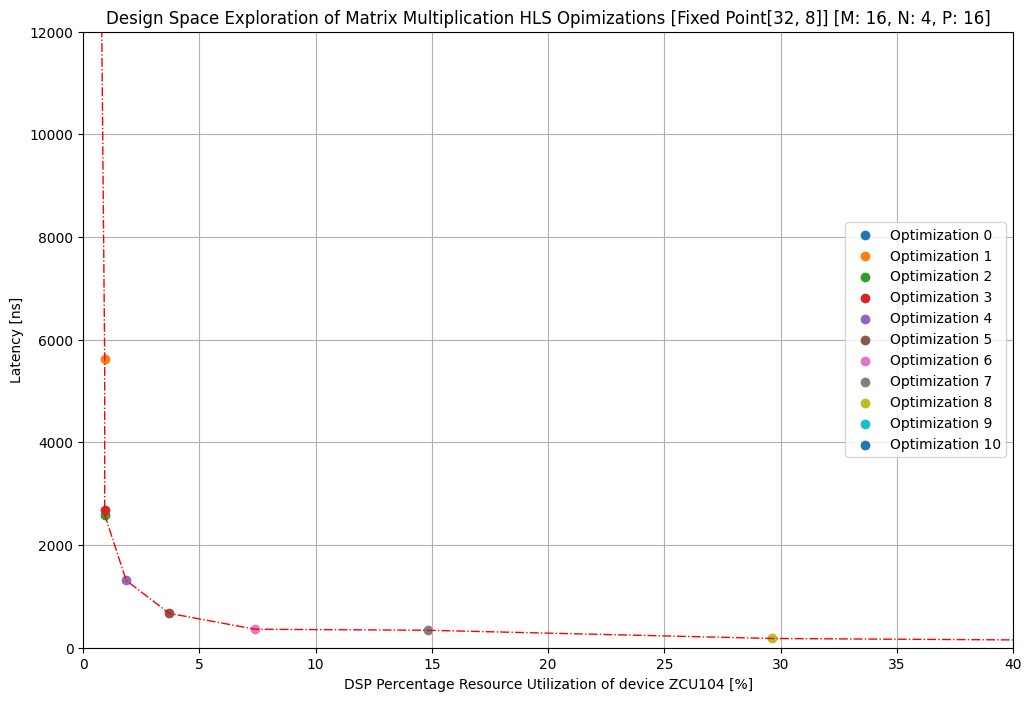

In [16]:
sorted_idx = np.argsort(dfResults["DSP%"])
x_sorted = dfResults["DSP%"][sorted_idx]
y_sorted = dfResults["Latency_ns"][sorted_idx]

# Find lower envelope points
lower_x = [x_sorted[0]]
lower_y = [y_sorted[0]]

for xi, yi in zip(x_sorted[1:], y_sorted[1:]):
    if yi < lower_y[-1]:
        lower_x.append(xi)
        lower_y.append(yi)
    else:
        # Keep previous lowest as a “step”
        lower_x.append(xi)
        lower_y.append(lower_y[-1])



fig = plt.figure()
fig.set_size_inches(12, 8)

ax = fig.add_subplot(1, 1, 1)

handles: list[any] = []
for i in range(len(dfResults["Latency_ns"])):
    handles.append(ax.scatter(dfResults["DSP%"][i], dfResults["Latency_ns"][i], label=dfResults.index[i]))

ax.plot(lower_x, lower_y, color='red', linewidth=1, linestyle="-.", label='Lower Barrier')

ax.legend(handles=handles, loc="center right")
ax.set_xlabel("DSP Percentage Resource Utilization of device ZCU104 [%]")
ax.set_ylabel("Latency [ns]")
ax.set_title("Design Space Exploration of Matrix Multiplication HLS Opimizations [Fixed Point[32, 8]] [M: 16, N: 4, P: 16]")
#ax.set_ylim([0, 12000])
#ax.set_xlim([0, 20])

ax.set_ylim([0, 12000])
ax.set_xlim([0, 40])

#ax.scatter(dfResults["(FF + LUT)%"], dfResults["Latency_ns"])
ax.grid(True)

In [17]:
reports.append(HLSReport(
    reportName="Report18",
    latency_ns=49610,
    bram=0,
    dsp=0,
    ff=421992,
    lut=786517,
    uram=0,
    taskSpecificInfo={
        "M": 197,
        "P": 32,
        "N": 197
    },
    optimizations=OptimizationStrategy(
        memory=[
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "C", dim=2, type=ArrayPartitionTypes.cyclic, factor=4
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=2, type=ArrayPartitionTypes.cyclic, factor=4
            )),
        ],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False), unroll=Unroll(off=False, factor=4)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))